[-- -- -- ..., -- -- --]
(array([   14,    89,   140,   192,   193,   206,   255,   325,   352,
         475,   555,   584,   646,   756,   781,   824,   977,   983,
        1021,  1058,  1115,  1150,  1152,  1162,  1165,  1188,  1194,
        1256,  1288,  1326,  1394,  1457,  1544,  1551,  1758,  1854,
        1897,  1983,  2017,  2057,  2094,  2130,  2288,  2294,  2299,
        2317,  2348,  2407,  2436,  2438,  2588,  2604,  2752,  2863,
        2899,  2943,  2950,  2999,  3154,  3287,  3364,  3406,  3411,
        3424,  3433,  3461,  3468,  3477,  3486,  3694,  3841,  3849,
        3899,  3901,  3943,  4005,  4271,  4314,  4501,  4556,  4641,
        4837,  4946,  5006,  5046,  5131,  5358,  5462,  5574,  5591,
        5611,  5669,  5701,  5817,  5877,  6007,  6023,  6043,  6186,
        6207,  6220,  6431,  6499,  6520,  6594,  6628,  6645,  6975,
        7056,  7147,  7219,  7481,  7532,  7878,  8067,  8087,  8107,
        8331,  8336,  8353,  8356,  8434,  8472,  8573,  8613,  

/usr/local/lib/python3.4/site-packages/scipy/io/netcdf.py:287: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


<function __main__.grid_box_details>

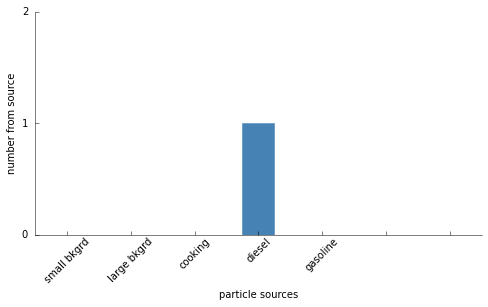

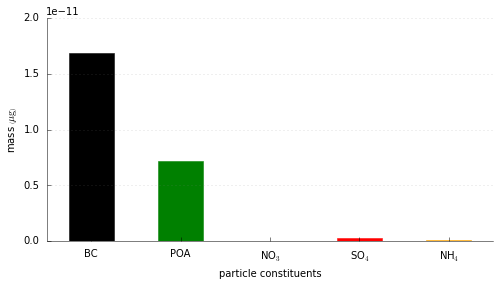

In [1]:
import numpy
import partmc3 as partmc
import scipy
import mpl_helper3 as mpl_helper
import config
import random
import matplotlib
import math
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets

def grid_box_details(x_bin, y_bin, time):
    # filename prefix
    dir = config.data_dir
    prefix = config.file_prefix
    filename =  '%s_%08i.nc' %(prefix,time)

    # Compute the black carbon mass fraction
    x_axis = partmc.log_grid(min=1e-9,max=1e-6,n_bin=60)
    bc_axis = partmc.linear_grid(min=0,max=1.,n_bin=50)

    x_centers = x_axis.centers()
    ncf = scipy.io.netcdf.netcdf_file(config.data_dir+'/'+filename, 'r')
    particles = partmc.aero_particle_array_t(ncf)
    env_state = partmc.env_state_t(ncf)
    aero_data = partmc.aero_data_t(ncf)
    ncf.close()

    bc = particles.masses(include = ["BC"])
    dry_mass = particles.masses(exclude = ["H2O"])
    bc_frac = bc / dry_mass

    dry_diameters = particles.dry_diameters()

    # Find the particles in a certain bin
    x_bins = x_axis.find(dry_diameters)
    y_bins = bc_axis.find(bc_frac)
    #print x_bins[0:10]
    #print y_bins[0:10]
    
    # make figure
    width_in = 7.0
    #(figure, axes, cbar_axes) = mpl_helper.make_fig(figure_width=width_in,
    #    colorbar=True,left_margin=.7,right_margin=1, top_margin=0.3,
    #    bottom_margin=.6, colorbar_height_fraction=0.8)

    # Pick a particle bin
    parts = []
    sources = particles.n_orig_parts
    # this could be better
    x_parts = numpy.ma.masked_not_equal(x_bins, x_bin)
    y_parts = numpy.ma.masked_not_equal(y_bins, y_bin)
    xx = numpy.ma.MaskedArray.nonzero(x_parts)
    yy = numpy.ma.MaskedArray.nonzero(y_parts)
    parts = list(set(xx[0]).intersection(yy[0]))
    #print parts
    print (x_parts)
    print (xx)
    
    # Randomly select from particles
    if (len(parts) == 0):
        print ('no particles in this bin')
        return

    index = random.choice(parts)
    print (str(len(parts)) + " particles found in bin")
    #print 'particle list', parts
    #print 'particle chosen', index

    # Get the sources
    strings = aero_data.source_names
    #print sources[:,index]
    #print strings
    
    # Make the figure of sources
    (fig, axes) = mpl_helper.make_fig(figure_width=width_in,
       axis_ratio=2,
       left_margin=.7,right_margin=.1, top_margin=0.25,
       bottom_margin=1.1, colorbar_height_fraction=0.8)
    width = .5
    x_values_source = numpy.arange(0,len(aero_data.source_names)) + .5*width

    segmentdata = {'red':   [(0.0,  0.0, 0.0),
                   (0.5,  1.0, 1.0),
                   (1.0,  1.0, 1.0)],

         'green': [(0.0,  0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0,  1.0, 1.0)],

         'blue':  [(0.0,  0.0, 0.0),
                   (0.5,  0.0, 0.0),
                   (1.0,  1.0, 1.0)]}
    sourcecolors = ['DarkBlue','DarkRed','DarkGreen','SteelBlue','DarkViolet']
    axes.bar(x_values_source, sources[:,index], width, color=sourcecolors,edgecolor=sourcecolors)
    
    # Make it pretty with labels
    axes.set_xticks(x_values_source+.5*width)
    axes.set_ylabel(r'number from source')
    axes.set_xlabel(r'particle sources')
    labels = ['small bkgrd','large bkgrd','cooking','diesel','gasoline']
    for tick in axes.get_xaxis().get_major_ticks():
        tick.set_pad(2.0)
        tick.label1 = tick._get_text1()
    axes.set_xticklabels(labels, rotation=45)
    axes.set_xlim([0,x_values_source[-1] + 1.5*width])
    max_sources = numpy.max(sources[:,index])+1
    axes.set_ylim([0,max_sources])
    axes.set_yticks(numpy.arange(0,max_sources+1))

    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)
    axes.get_xaxis().tick_bottom()
    axes.get_yaxis().tick_left()

    # Save the figure
    #fig.savefig('figs/particle_sources_%08i.png'
    #    %(time))
    
    # Make a figure regarding the mass distribution of species
    # What species we want?
    species_list = ['BC', 'OC', 'NO3', 'SO4', 'NH4']
    colors = ['black','green','blue','red','orange']
    values = numpy.zeros(len(species_list))
    for ii, value in enumerate(species_list):
        species_masses = particles.masses(include=[value])
        values[ii] = species_masses[index]  
    # Convert units from kg to micrograms
    values *= 1e9
    
    # Make the figure
    (fig, axes) = mpl_helper.make_fig(figure_width=width_in,
        axis_ratio=2,
        left_margin=.7,right_margin=.1, top_margin=0.25,
        bottom_margin=.55, colorbar_height_fraction=0.8)
    x_values = numpy.arange(0,len(species_list)) + .5*width
    axes.grid(b='on',which='major',axis='y',color='gray')
    axes.bar(x_values, values,width,color=colors,edgecolor=colors)
    axes.set_ylabel(r'mass $\left(\mu\rm g\right)$')
    axes.set_xlabel(r'particle constituents')
    axes.set_xticks(x_values+.5*width)
    axes.grid(b='on',which='major',axis='y',color='gray',alpha=.5, linestyle=':')

    latex_labels = []
    for ii,spec in enumerate(species_list):
        latex_labels.append(aero_data.species_tex_names[spec])
    axes.set_xticklabels(latex_labels,verticalalignment='top')
    axes.set_xlim([0,x_values[-1] + 1.5*width])
    max_value = (numpy.ceil(numpy.max(values) / 10**numpy.floor(numpy.log10(numpy.max(values)))))*10**numpy.floor(numpy.log10(numpy.max(values)))
    axes.set_ylim([0,max_value])
    axes.set_yticks(numpy.arange(0,max_value+1e-12,.5*10**numpy.floor(numpy.log10(numpy.max(values)))))
    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)
    axes.get_xaxis().tick_bottom()
    axes.get_yaxis().tick_left()
    #for label in axes.yaxis.get_ticklabels()[1:6:2]:
    #  print label
    #  label.set_visible(False)
    #fig.savefig('figs/particle_composition_%08i.png'
    #    %(time))
    
    plt.plot()
    
    return

# main program
interact(grid_box_details,
         x_bin=widgets.IntSlider(min=0,max=60,value=30),
         y_bin=widgets.IntSlider(min=0,max=50,value=30),
         time=widgets.IntSlider(min=1,max=24,value=12))
